Defining Quic server and its functions.


In [1]:
import socket
import struct
import time
import select
import matplotlib.pyplot as plt

class QuicServer:
    local_port = 12345
    packet_size = 1024
    ready_message = b"READY"  # Message to indicate that the server is ready to receive data (Identify new iteration)
    finished_message = b"FINISHED"  # Message to indicate that the server has received all data
    timeout_duration = 30  # Timeout duration for receiving data from the client
    num_iterations = 10

    # Initialize the server
    def __init__(self):
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.bind(('', self.local_port))
        self.stream_data = {}  # Stores data per stream per iteration
        self.total_bytes_received = 0
        self.total_packets_received = 0
        self.start_time = {} # Contains starting time of each stream per iteration
        self.end_time = {} # Contains ending time for each stream per iteration
        self.iteration = 0 # Iteration counter
        self.iteration_metrics = []  # To store average metrics for each iteration
        self.socket.settimeout(self.timeout_duration)

    # Close the connection
    def close_connection(self):
        self.socket.close()
        print("Connection closed.")

    # Process the initial message sent by the client
    # Used to extract the number of streams and file size
    def process_initial_message(self):
        try:
            initial_message, sender_address = self.socket.recvfrom(8) 
            if len(initial_message) < 8:
                raise ValueError("Initial message is too short")
            sender_ip, _ = sender_address
            num_streams, file_size = struct.unpack("!II", initial_message)
            return sender_ip, num_streams, file_size
        except self.socket.timeout:
            print("Timeout reached while waiting for initial message")
            self.close_connection()
            exit(1)

    # Update statistics for the received stream
    def update_statistics(self, received_stream_id, data):
        if self.iteration not in self.stream_data:
            self.stream_data[self.iteration] = {}
        if received_stream_id not in self.stream_data[self.iteration]:
            self.stream_data[self.iteration][received_stream_id] = {"bytes_received": 0, "packets_received": 0}
            self.start_time[(self.iteration, received_stream_id)] = time.perf_counter()
        self.stream_data[self.iteration][received_stream_id]["bytes_received"] += len(data)
        self.stream_data[self.iteration][received_stream_id]["packets_received"] += 1

        self.total_bytes_received += len(data)
        self.total_packets_received += 1

    # Receive packets from the client and collect data
    def receive_packets(self, num_streams):
        try:
            received_data = {}
            end_packets_received = 0  # Track the number of "END" packets received for all streams
            while end_packets_received < num_streams:  # Continue until all streams have sent their "END" packets
                ready, _, _ = select.select([self.socket], [], [], 1)  # Wait for 1 second for incoming data
                if not ready:
                    break  # Timeout reached, exit loop
                data, _ = self.socket.recvfrom(self.packet_size + 4)  # 4 bytes for stream_id
                received_stream_id = struct.unpack("!I", data[:4])[0]
                if data[4:] == b"END":
                    end_packets_received += 1  # Increment the count of "END" packets received
                    self.end_time[(self.iteration, received_stream_id)] = time.perf_counter() # Count end time for stream
                    continue  # Skip processing "END" packet as it does not contain data
                if received_stream_id not in received_data:
                    received_data[received_stream_id] = b""
                received_data[received_stream_id] += data[4:]
                self.update_statistics(received_stream_id, data[4:])  # Update statistics for the received stream
            return received_data
        except self.socket.timeout:
            print("Timeout reached while waiting for data packets")
            self.close_connection()
            exit(1)

    # Send a message to the client to indicate that the server is ready to receive data (Identify new iteration)
    def send_ready_message(self, sender_ip):
        server_address = (sender_ip, self.local_port + 1)
        with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
            sock.sendto(self.ready_message, server_address)

    # Send a message to the client to indicate that the server has received all data (End of all iterations)
    def send_finished_message(self, sender_ip):
        server_address = (sender_ip, self.local_port + 1)
        with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
            sock.sendto(self.finished_message, server_address)

    # Calculate metrics for the received data
    def calculate_metrics(self):
        metrics = {}
        for iteration, streams in self.stream_data.items():
            total_iteration_avg_bytes_per_ms = 0
            total_iteration_avg_packets_per_ms = 0
            iteration_metrics = {}
            for stream_id, data in streams.items():
                end_time = self.end_time.get((iteration, stream_id))
                start_time = self.start_time.get((iteration, stream_id))
                if end_time is not None and start_time is not None:
                    elapsed_time_ms = (end_time - start_time) * 1000
                    if elapsed_time_ms == 0:
                        elapsed_time_ms = 1
                    avg_bytes_per_ms = data["bytes_received"] / elapsed_time_ms
                    avg_packets_per_ms = data["packets_received"] / elapsed_time_ms
                    iteration_metrics[stream_id] = {
                        "bytes_transferred": data["bytes_received"],
                        "packets_transferred": data["packets_received"],
                        "average_bytes_per_millisecond": avg_bytes_per_ms,
                        "average_packets_per_millisecond": avg_packets_per_ms,
                    }
                    total_iteration_avg_bytes_per_ms += avg_bytes_per_ms
                    total_iteration_avg_packets_per_ms += avg_packets_per_ms
            metrics[iteration] = iteration_metrics
            iteration_avg_bytes_per_ms = total_iteration_avg_bytes_per_ms / len(streams) if streams else 0
            iteration_avg_packets_per_ms = total_iteration_avg_packets_per_ms / len(streams) if streams else 0
            self.iteration_metrics.append({
                "average_bytes_per_millisecond": iteration_avg_bytes_per_ms,
                "average_packets_per_millisecond": iteration_avg_packets_per_ms,
                "num_streams": len(streams)
            })
        return metrics

    # Print statistics for the received data
    def print_statistics(self, metrics, file_size):
        print(f"\nFile size: {file_size}:")
        for iteration, streams in metrics.items():
            print(f"\nIteration {iteration}:")
            for stream_id, metric in streams.items():
                print(f"\nStream {stream_id}:")
                print(f"Bytes transferred: {metric['bytes_transferred']}")
                print(f"Packets transferred: {metric['packets_transferred']}")
                print(f"Average bytes per millisecond: {metric['average_bytes_per_millisecond']}")
                print(f"Average packets per millisecond: {metric['average_packets_per_millisecond']}")
            avg_metrics = self.iteration_metrics[iteration-1]
            print(f"\nIteration {iteration} Averages:")
            print(f"Average bytes per millisecond: {avg_metrics['average_bytes_per_millisecond']}")
            print(f"Average packets per millisecond: {avg_metrics['average_packets_per_millisecond']}")

    # Plot metrics for the received data
    def plot_metrics(self):
        avg_bytes_per_ms = [metrics["average_bytes_per_millisecond"] for metrics in self.iteration_metrics]
        avg_packets_per_ms = [metrics["average_packets_per_millisecond"] for metrics in self.iteration_metrics]
        num_streams = [metrics["num_streams"] for metrics in self.iteration_metrics]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(num_streams, avg_bytes_per_ms, marker='o')
        plt.title('Average Bytes / Millisecond per Iteration vs Number of Streams')
        plt.xlabel('Number of Streams')
        plt.ylabel('Average Bytes / Millisecond per Iteration')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(num_streams, avg_packets_per_ms, marker='o')
        plt.title('Average Packets / Millisecond per Iteration vs Number of Streams')
        plt.xlabel('Number of Streams')
        plt.ylabel('Average Packets / Millisecond per Iteration')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Run the server
    # Prints statistics and plots metrics for the received data
    def run(self):
        for _ in range(self.num_iterations):
            sender_ip, num_streams, file_size = self.process_initial_message()
            self.iteration += 1
            received_data = self.receive_packets(num_streams)
            if self.iteration < self.num_iterations:
                self.send_ready_message(sender_ip)
            elif self.iteration == self.num_iterations:
                self.send_finished_message(sender_ip)
            elif self.iteration > self.num_iterations:
                print(f"Invalid iteration {self.iteration}")
        return file_size


Creating the server and receiving data.

The server receives an initial message that includes the amount of streams and the size of the file being transferred.
The server uses that information to appropriately receive the file over multiple streams.
For each stream and iteration, the server receives the file while updating the statistics.

In [2]:
server = QuicServer()
file_size = server.run()

Printing the statistics

The server calculates the averages and prints them as well as the details gathered.

In [3]:
metrics = server.calculate_metrics()
server.print_statistics(metrics, file_size)


File size: 1187767:

Iteration 1:

Stream 1:
Bytes transferred: 1187767
Packets transferred: 1160
Average bytes per millisecond: 1378.4991791204634
Average packets per millisecond: 1.3462733413032502

Iteration 1 Averages:
Average bytes per millisecond: 1378.4991791204634
Average packets per millisecond: 1.3462733413032502

Iteration 2:

Stream 1:
Bytes transferred: 1187767
Packets transferred: 1160
Average bytes per millisecond: 665.5931777822564
Average packets per millisecond: 0.6500332861810586

Stream 2:
Bytes transferred: 1187767
Packets transferred: 1160
Average bytes per millisecond: 665.8651546027297
Average packets per millisecond: 0.6502989048686876

Iteration 2 Averages:
Average bytes per millisecond: 665.729166192493
Average packets per millisecond: 0.6501660955248731

Iteration 3:

Stream 1:
Bytes transferred: 1187767
Packets transferred: 1160
Average bytes per millisecond: 431.67130780750426
Average packets per millisecond: 0.42157992018359236

Stream 2:
Bytes transferr

Creating graphs

The server uses the data collected over each iteration and shows a graph that compares packet & byte received against amount of streams in each iteration.

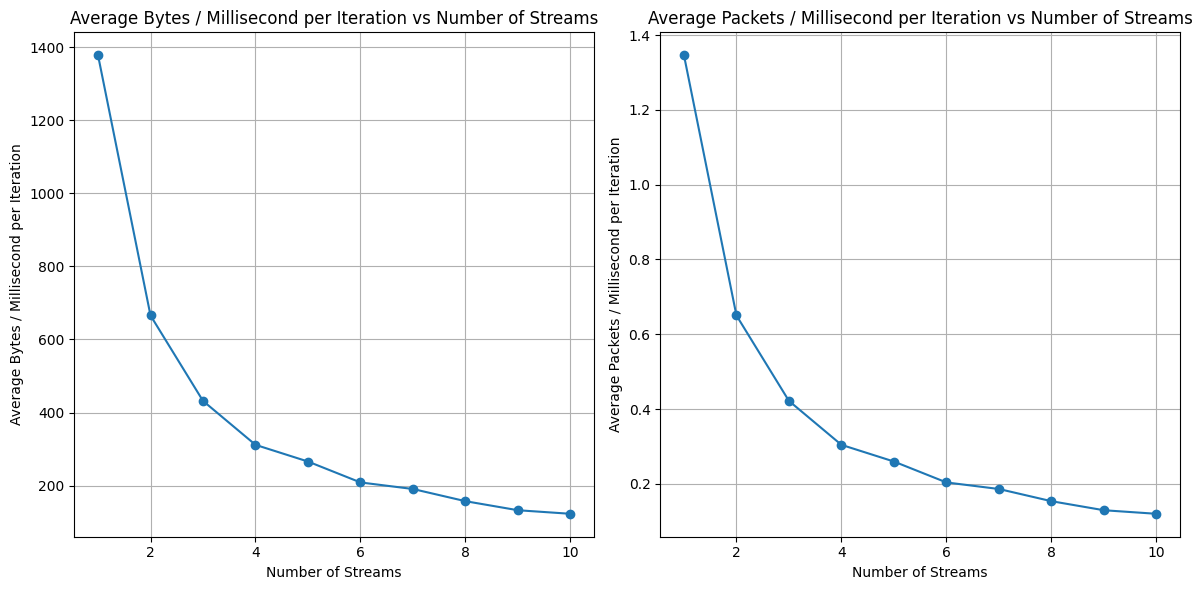

In [4]:
server.plot_metrics()